In [30]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn
import jax

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from torch.utils.data import DataLoader, TensorDataset

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import corner

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

In [31]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # First layer maps input_dim to 256 neurons
            nn.LeakyReLU(),
            nn.Linear(512, 256),  # 2
            nn.LeakyReLU(),
            nn.Linear(256, 128),  # 3
            nn.LeakyReLU(),
            nn.Linear(128, 64),  # 4
            nn.LeakyReLU(),
            nn.Linear(64, 32),  # 5
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=25, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }
    
ckpt_path = "best_model_v9-1-SS---epoch=8563-val_loss=0.00008340.ckpt" 
input_dim = 7  # Number of input features
output_dim = 5  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  

GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=32, out_features=5, bias=True)
  )
  (criterion): MSELoss()
)

In [32]:
import joblib

scaler_X = joblib.load('scalerXV9.pkl')
scaler_y = joblib.load('scalerYV9.pkl')

In [33]:
import jax.numpy as jnp

# List of 10 specific track names
track_names = ['track01624', 'track01975', 'track08968', 'track02584', 'track04056',
               'track05847', 'track05944', 'track06984', 'track07032', 'track07783']

print(len(track_names))

# Dictionary to store extracted data
star_data = {}

# Open HDF5 file and extract data for each track
with h5py.File(garstec_data, 'r') as hdf:
    for track_name in track_names:
        specific_track = hdf['grid']['tracks'][track_name]

        # Extract parameters and reshape where needed
        star_data[track_name] = {
            'age': specific_track['age'][:].reshape(-1, 1),
            'massini': specific_track['massini'][:].reshape(-1, 1),
            'fehini': specific_track['FeHini'][:].reshape(-1, 1),
            'alphamlt': specific_track['alphaMLT'][:].reshape(-1, 1),
            'yini': specific_track['yini'][:].reshape(-1, 1),
            'eta': specific_track['eta'][:].reshape(-1, 1),
            'alphafe': specific_track['alphaFe'][:].reshape(-1, 1),

            # Observational values (no reshape needed)
            'teff': specific_track['Teff'][:],
            'luminosity': specific_track['LPhot'][:],
            'dnufit': specific_track['dnufit'][:],
            'FeH': specific_track['FeH'][:],
            'numax': specific_track['numax'][:]
        }

        # Select middle age index
        index = len(star_data[track_name]['age']) // 2

        # Extract single values at the middle index
        star_data[track_name]['selected'] = {
            'age': star_data[track_name]['age'][index],
            'massini': star_data[track_name]['massini'][index],
            'fehini': star_data[track_name]['fehini'][index],
            'alphamlt': star_data[track_name]['alphamlt'][index],
            'yini': star_data[track_name]['yini'][index],
            'eta': star_data[track_name]['eta'][index],
            'alphafe': star_data[track_name]['alphafe'][index],

            'teff': star_data[track_name]['teff'][index],
            'luminosity': star_data[track_name]['luminosity'][index],
            'dnufit': star_data[track_name]['dnufit'][index],
            'FeH': star_data[track_name]['FeH'][index],
            'numax': star_data[track_name]['numax'][index]
        }




10


In [34]:
# Dictionary to store results
predictions_dict = {}
epsilon = 1e-10

# Iterate through each track
for track_name in track_names:
    # Extract the stored middle index data for each star
    age = star_data[track_name]['selected']['age']
    massini = star_data[track_name]['selected']['massini']
    fehini = star_data[track_name]['selected']['fehini']
    alphamlt = star_data[track_name]['selected']['alphamlt']
    yini = star_data[track_name]['selected']['yini']
    eta = star_data[track_name]['selected']['eta']
    alphafe = star_data[track_name]['selected']['alphafe']

    # Apply log10 transformation where necessary
    log10_inputs = [age, massini, alphamlt, eta, yini]
    log10_transformed_inputs = [np.log10(np.maximum(data, epsilon)) for data in log10_inputs]

    # Combine log-transformed inputs with raw `fehini` and `alphafe`
    features_real = np.hstack(log10_transformed_inputs + [fehini, alphafe])

    # Convert to NumPy array for scaling
    features_numpy_real = np.array(features_real).reshape(1, -1)  # Ensure correct shape

    # Apply scaling
    features_scaled_real = scaler_X.transform(features_numpy_real)

    # Convert scaled inputs to PyTorch tensor
    features_tensor_real = torch.FloatTensor(features_scaled_real)

    # Make predictions using the model
    model.eval()
    with torch.no_grad():
        predictions = model(features_tensor_real).numpy()  # Predict
        predictions = scaler_y.inverse_transform(predictions)  # Inverse transform

    # Extract predicted values
    teff = 10**predictions[:, 0]  # Inverse log10 transformation
    luminosity = 10**predictions[:, 1]
    dnu = 10**predictions[:, 2]
    numax = 10**predictions[:, 3]
    FeH = predictions[:, 4]  # FeH does not require log transformation

    # Store results in the dictionary
    predictions_dict[track_name] = {
        'teff': teff[0],
        'luminosity': luminosity[0],
        'dnu': dnu[0],
        'numax': numax[0],
        'FeH': FeH[0]
    }

In [35]:
# Print selected data for all stars
for track_name in track_names:
    print(f"\nSelected data for {track_name}:")
    for key, value in star_data[track_name]['selected'].items():
        print(f"  {key}: {value}")


Selected data for track01624:
  age: [10018.17118]
  massini: [0.845]
  fehini: [-1.05361328]
  alphamlt: [1.97304687]
  yini: [0.27909668]
  eta: [0.17797852]
  alphafe: [0.2]
  teff: 5029.081279
  luminosity: 58.13098507540302
  dnufit: 3.770210069783087
  FeH: -1.0436679355001754
  numax: 0.008890951555915818

Selected data for track01975:
  age: [12616.35002]
  massini: [0.869]
  fehini: [-0.70556641]
  alphamlt: [1.61523438]
  yini: [0.25497559]
  eta: [0.15864258]
  alphafe: [0.2]
  teff: 4619.104165
  luminosity: 41.33889352574103
  dnufit: 3.85436674208666
  FeH: -0.6940054574740909
  numax: 0.009556647780866819

Selected data for track08968:
  age: [8840.709019]
  massini: [0.854]
  fehini: [-1.6260376]
  alphamlt: [1.53208008]
  yini: [0.27439148]
  eta: [0.15650024]
  alphafe: [0.2]
  teff: 5005.701981
  luminosity: 49.638260036401455
  dnufit: 4.291318184571222
  FeH: -1.6176067228259974
  numax: 0.01036113645753787

Selected data for track02584:
  age: [10994.70683]
  mas

In [36]:
# List of 10 specific track names
track_names = ['track01624', 'track01975', 'track08968', 'track02584', 'track04056',
               'track05847', 'track05944', 'track06984', 'track07032', 'track07783']

# Dictionary to store extracted data
selected_data = {  
    'age': [], 'massini': [], 'fehini': [], 'alphamlt': [], 'yini': [], 'eta': [], 'alphafe': [],
    'teff': [], 'luminosity': [], 'dnufit': [], 'FeH': [], 'numax': []
}

# Open HDF5 file and extract data for each track
with h5py.File(garstec_data, 'r') as hdf:
    for track_name in track_names:
        specific_track = hdf['grid']['tracks'][track_name]

        # Select middle age index
        index = len(specific_track['age']) // 2

        # Append selected values to lists
        selected_data['age'].append(specific_track['age'][index].item())
        selected_data['massini'].append(specific_track['massini'][index].item())
        selected_data['fehini'].append(specific_track['FeHini'][index].item())
        selected_data['alphamlt'].append(specific_track['alphaMLT'][index].item())
        selected_data['yini'].append(specific_track['yini'][index].item())
        selected_data['eta'].append(specific_track['eta'][index].item())
        selected_data['alphafe'].append(specific_track['alphaFe'][index].item())
        selected_data['teff'].append(specific_track['Teff'][index].item())
        selected_data['luminosity'].append(specific_track['LPhot'][index].item())
        selected_data['dnufit'].append(specific_track['dnufit'][index].item())
        selected_data['FeH'].append(specific_track['FeH'][index].item())
        selected_data['numax'].append(specific_track['numax'][index].item())

# Print min/max values for each parameter
print("\nMin/Max values across all tracks:")
for key, values in selected_data.items():
    print(f"{key}: min = {min(values)}, max = {max(values)}")



Min/Max values across all tracks:
age: min = 8621.133586, max = 12616.35002
massini: min = 0.81, max = 0.893
fehini: min = -1.82006836, max = -0.458764648
alphamlt: min = 1.50107422, max = 2.25830078
yini: min = 0.25213501, max = 0.286872559
eta: min = 0.120629883, max = 0.189880371
alphafe: min = 0.2, max = 0.2
teff: min = 4619.104165, max = 5288.697216
luminosity: min = 41.33889352574103, max = 65.70164760790432
dnufit: min = 3.770210069783087, max = 4.387724052822876
FeH: min = -1.8127530609253273, max = -0.446234204280798
numax: min = 0.008890951555915818, max = 0.010679177802501357


In [37]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    mean_x = jnp.array(scaler_X.mean_)
    scale_x = jnp.array(scaler_X.scale_)

    # Add batch dimension to scaling parameters
    if x.ndim > mean_x.ndim:
        # Expand dimensions to allow broadcasting across batch
        mean_x = mean_x[None, :]
        scale_x = scale_x[None, :]  
            
    x = (x - mean_x) / scale_x

    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]

    # Add batch dimension to y scaling parameters if needed

    mean_y = jnp.array(scaler_y.mean_)
    std_y = jnp.array(scaler_y.scale_)

    if x.ndim > mean_y.ndim:
        mean_y = mean_y[None, :]
        std_y = std_y[None, :]
            
    y = x * std_y + mean_y

    return y

In [38]:
# Get the first teff value from each track and store it in an array
teff_values = [star_data[track]['teff'][0] for track in track_names]
lum_values = [star_data[track]['luminosity'][0] for track in track_names]
dnufit_values = [star_data[track]['dnufit'][0] for track in track_names]
FeH_values = [star_data[track]['FeH'][0] for track in track_names]
numax_values = [star_data[track]['numax'][0] for track in track_names]

In [39]:
# For observational data
obs_err = {
    'teff_err': [70],
    'lum_err': [5],
    'dnu_err': [0.1],
    'feh_err': [0.1],
    'numax_err': [0.5]
}

# Initialize lists to store observations
teff_obs_list = []
lum_obs_list = []
dnu_obs_list = []
feh_obs_list = []
numax_obs_list = []

for i in range(len(track_names)):
    teff_obs = teff_values[i] + np.random.randn() * obs_err['teff_err'][0]
    lum_obs = lum_values[i] + np.random.randn() * obs_err['lum_err'][0]
    dnu_obs = dnufit_values[i] + np.random.randn() * obs_err['dnu_err'][0]
    feh_obs = FeH_values[i] + np.random.randn() * obs_err['feh_err'][0]  # Fixed error term
    numax_obs = numax_values[i] * sun_numax + np.random.randn() * obs_err['numax_err'][0]
    
    # Append to lists
    teff_obs_list.append(teff_obs)
    lum_obs_list.append(lum_obs)
    dnu_obs_list.append(dnu_obs)
    feh_obs_list.append(feh_obs)
    numax_obs_list.append(numax_obs)

# Convert observations to arrays
teff_obs = jnp.array(teff_obs_list)
lum_obs = jnp.array(lum_obs_list)
dnu_obs = jnp.array(dnu_obs_list)
feh_obs = jnp.array(feh_obs_list)
numax_obs = jnp.array(numax_obs_list)

# Create observation dictionary with all observations
obs = {
    'teff': teff_obs,
    'lum': lum_obs,
    'dnu': dnu_obs,
    'feh': feh_obs,
    'numax': numax_obs,
}

In [40]:
"""
teff_obs = teff_emu + np.random.randn() * obs_err['teff_err'][0]
lum_obs = lum_emu + np.random.randn() * obs_err['lum_err'][0]
dnu_obs = dnu_emu + np.random.randn() * obs_err['dnu_err'][0]
FeH_obs = FeH_emu + np.random.randn() * obs_err['lum_err'][0]
numax_obs = numax_emu * sun_numax + np.random.randn() * obs_err['numax_err'][0]
"""

"\nteff_obs = teff_emu + np.random.randn() * obs_err['teff_err'][0]\nlum_obs = lum_emu + np.random.randn() * obs_err['lum_err'][0]\ndnu_obs = dnu_emu + np.random.randn() * obs_err['dnu_err'][0]\nFeH_obs = FeH_emu + np.random.randn() * obs_err['lum_err'][0]\nnumax_obs = numax_emu * sun_numax + np.random.randn() * obs_err['numax_err'][0]\n"

In [41]:
def Bmodel(obs=None):
    with numpyro.plate("star", 10):
        # Define priors
        massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(1.5, 3)) + 0.7)
        tau_hat = numpyro.deterministic("tau_hat", 4 * numpyro.sample("tau_hat_s", dist.Beta(1.25, 2)) + 1) 
        
        # Calculate values for joint prior
        tau_ms = (2500) * (massini_**-3.15)
        ages_ = numpyro.deterministic("ages_", jnp.minimum(tau_hat * tau_ms, 20000))
        
        # Rest of priors
        alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 1.5)
        yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.22)
        eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 2)))
        alphafe_ = numpyro.deterministic("alphafe_", 0.8 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.2)
        fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2) 
        
    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, yini_] 
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
        
    # Stack features
    x = jnp.stack([*log_transformed_inputs, fehini_, alphafe_], axis=1)
        
    # Emulate using PyTorch model
    y = emulate(x)
        
    # Extract predictions
    teff = numpyro.deterministic("teff", jnp.power(10.0, y[..., 0])) 
    lum = numpyro.deterministic("lum", jnp.power(10.0, y[..., 1])) 
    dnu = numpyro.deterministic("dnu", jnp.power(10.0, y[..., 2]))
    numax = numpyro.deterministic("numax", jnp.power(10.0, y[..., 3])) * sun_numax
    feh = numpyro.deterministic("feh", y[..., 4])
        
    # Observational likelihoods
    if obs is not None:
        num_obs = len(obs['teff'])
            
        # Sample observations
        numpyro.sample("teff_obs", dist.StudentT(5, teff, obs_err['teff_err'][0]), obs=teff_obs)
        numpyro.sample("lum_obs", dist.StudentT(5, lum, obs_err['lum_err'][0]), obs=lum_obs)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, obs_err['dnu_err'][0]), obs=dnu_obs)
        numpyro.sample("feh_obs", dist.StudentT(5, feh, obs_err['feh_err'][0]), obs=feh_obs)
        numpyro.sample("numax_obs", dist.StudentT(5, numax, obs_err['numax_err'][0]), obs=numax_obs)

In [42]:
from jax import random
from numpyro.infer import Predictive
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4) # between 1000 and 4000 for testing 
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_27244\4120305975.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=4) # between 1000 and 4000 for testing
sample: 100%|██████████| 2000/2000 [14:32<00:00,  2.29it/s, 1023 steps of size 2.83e-04. acc. prob=0.95]


In [45]:
import arviz as az

trace = az.from_numpyro(mcmc)

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_[0],11109.753,1112.695,8824.848,13140.883,236.562,169.531,22.0,134.0,1.13
ages_[1],7287.815,5435.265,2653.575,17889.232,2667.175,2037.015,5.0,19.0,2.31
ages_[2],8820.545,716.597,7589.952,10177.881,196.156,142.780,13.0,72.0,1.24
ages_[3],11348.955,1591.624,8054.973,14274.628,593.120,442.839,7.0,25.0,1.56
ages_[4],8755.182,1094.247,6939.750,10685.635,295.364,213.460,14.0,40.0,1.21
...,...,...,...,...,...,...,...,...,...
yini_s[5],0.370,0.163,0.156,0.797,0.064,0.049,8.0,15.0,1.43
yini_s[6],0.465,0.230,0.097,0.875,0.096,0.072,6.0,16.0,1.83
yini_s[7],0.261,0.123,0.034,0.487,0.044,0.032,7.0,14.0,1.52
yini_s[8],0.319,0.153,0.071,0.600,0.061,0.045,7.0,37.0,1.64


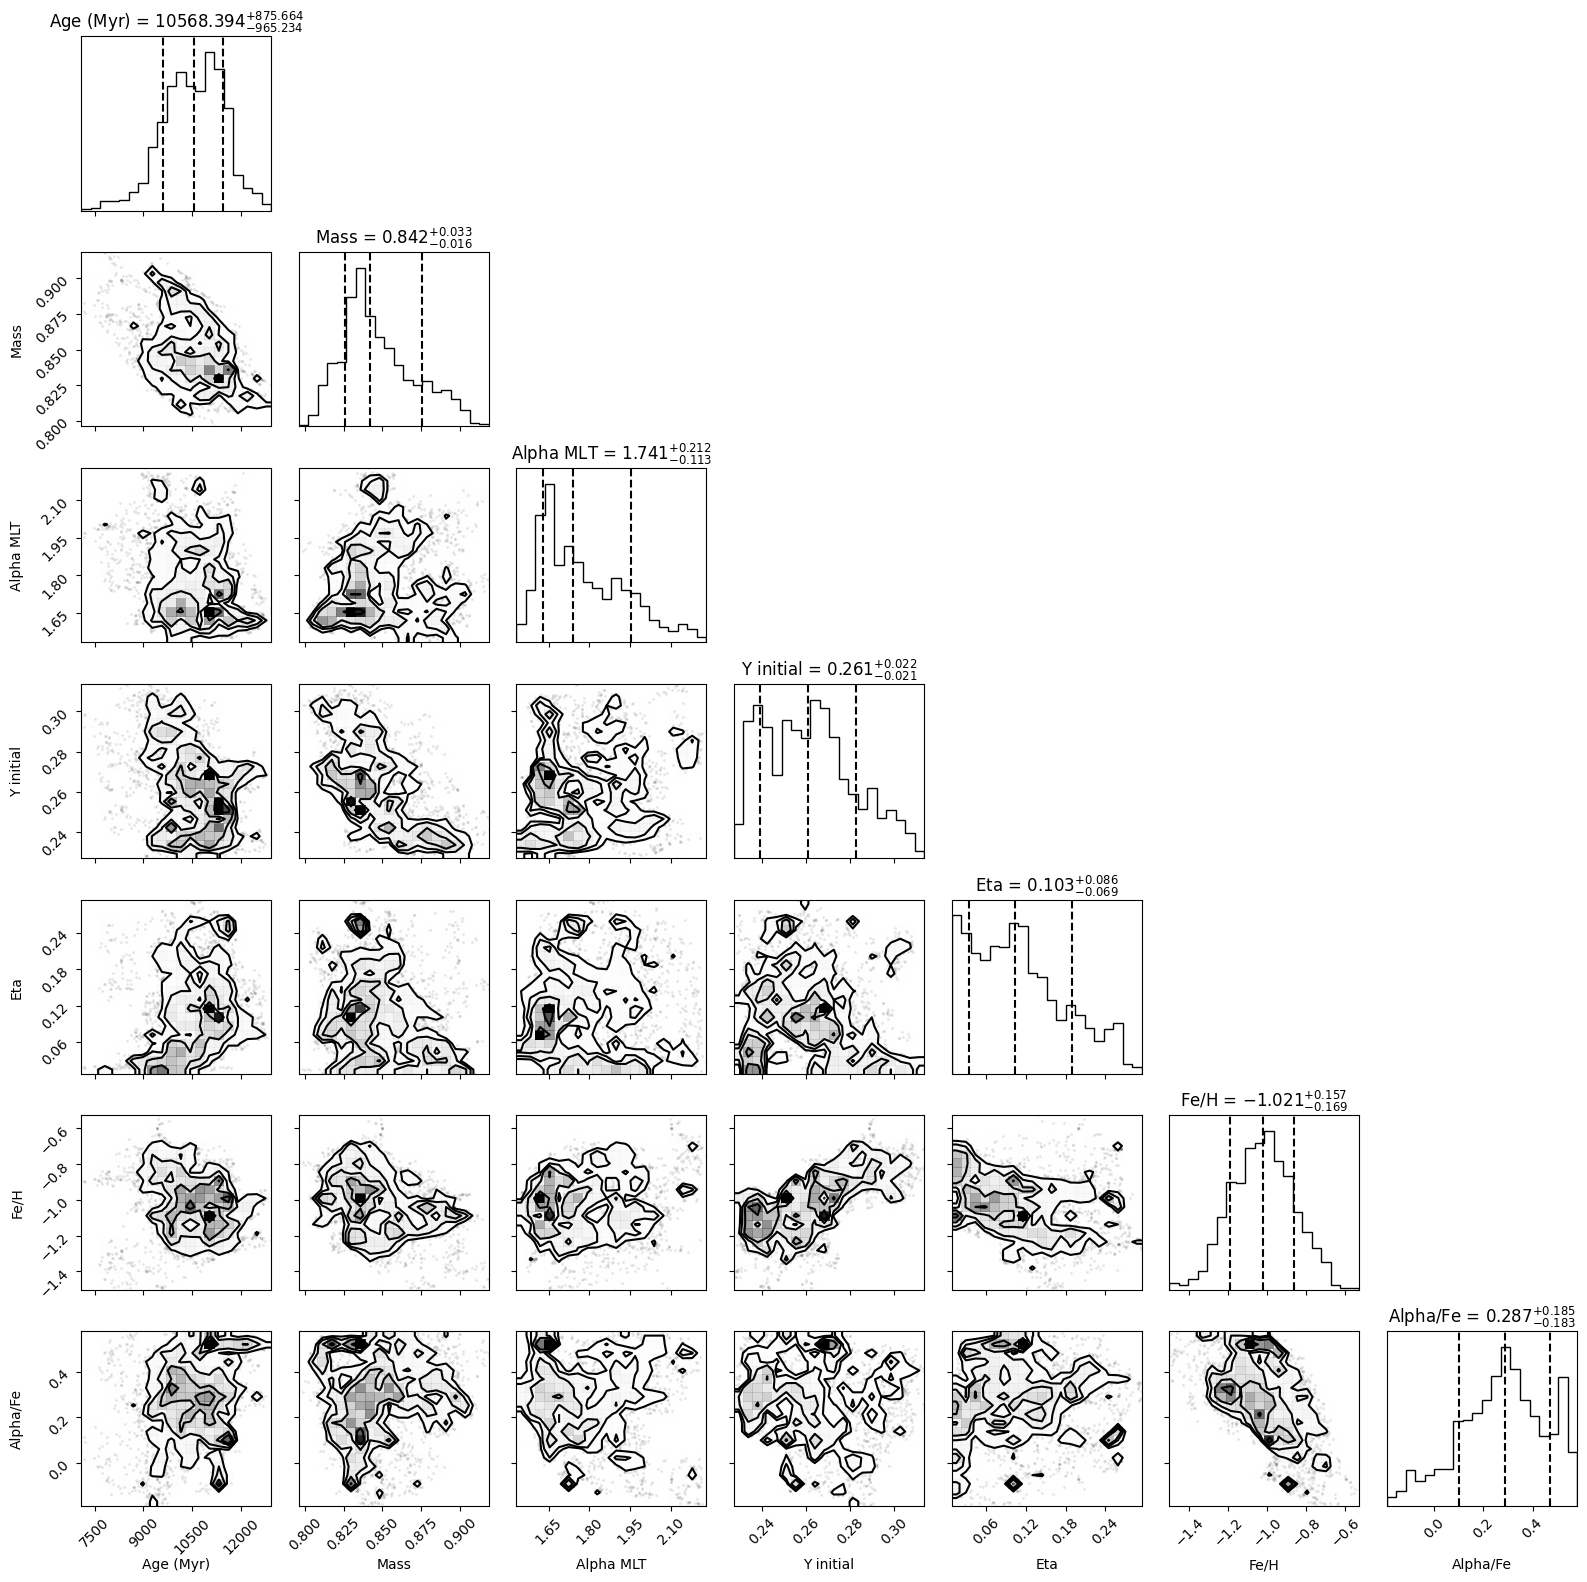

In [54]:
import corner
import numpy as np
import matplotlib.pyplot as plt

samples = mcmc.get_samples()

# Index

i = 8

params_of_interest = {
    'Age (Myr)': samples['ages_'][..., i],
    'Mass': samples['massini_'][..., i],
    'Alpha MLT': samples['alphamlt_'][..., i],
    'Y initial': samples['yini_'][..., i],
    'Eta': samples['eta_'][..., i],
    'Fe/H': samples['fehini_'][..., i],
    'Alpha/Fe': samples['alphafe_'][..., i]
}

# Convert to a numpy array for corner.py
X = np.column_stack([params_of_interest[key] for key in params_of_interest])
labels = list(params_of_interest.keys())


fig = corner.corner(
    X, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt='.3f'
)

plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_27244\1268981575.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


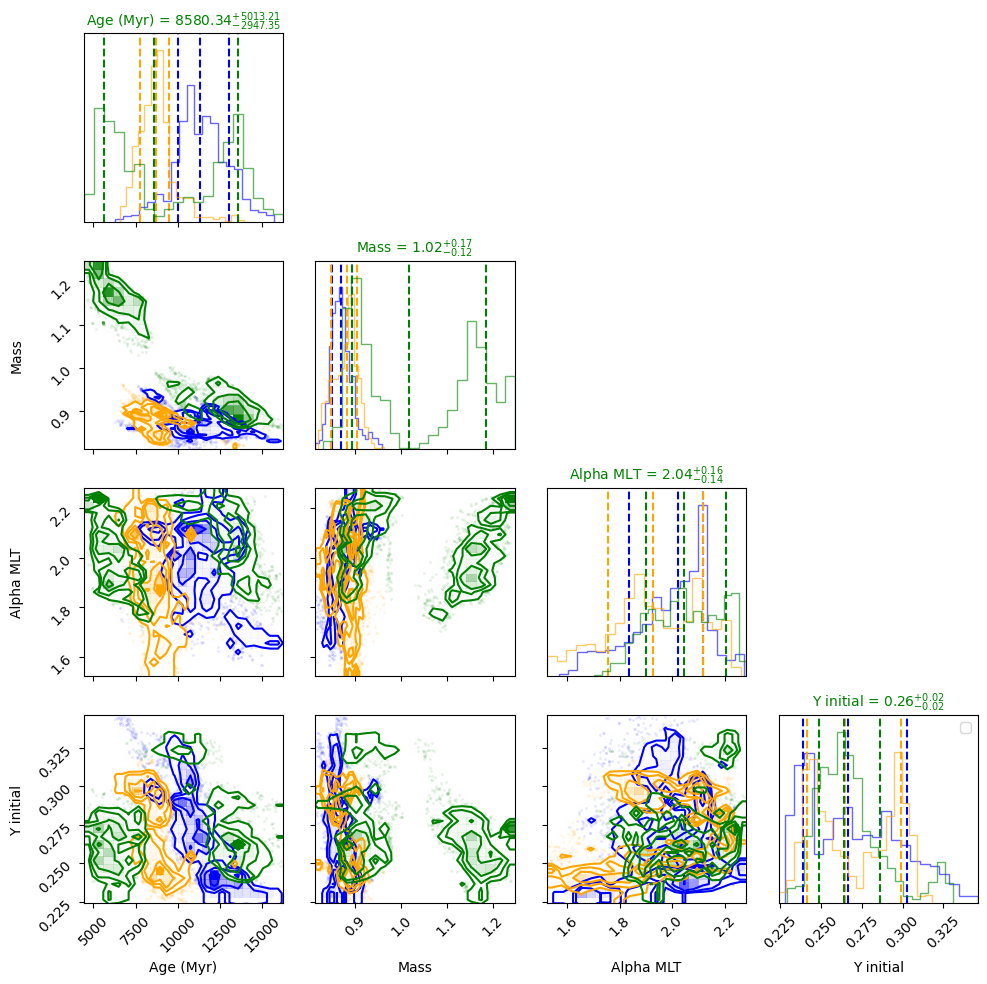

In [ ]:
# Create a figure for the corner plot
fig = plt.figure(figsize=(10, 10))

# Parameters to include
params = ['ages_', 'massini_', 'alphamlt_', 'yini_']
labels = ['Age (Myr)', 'Mass', 'Alpha MLT', 'Y initial']

# Colors for different stars
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot each star's corner plot with a different color
for star_idx in range(min(3, len(samples['ages_'][0]))):  # Plot up to 5 stars
    # Extract samples for this star
    X = np.column_stack([samples[param][..., (star_idx)] for param in params])
    
    # Add the corner plot for this star
    corner.corner(
        X, 
        labels=labels,
        fig=fig,
        color=colors[star_idx],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 10, "color": colors[star_idx]},
        hist_kwargs={"alpha": 0.6},
        label=f'Star {star_idx+1}'
    )

plt.tight_layout()
plt.legend()
plt.show()